# Linear Elasticity

In this example, we solve a displacement-based FFT problem for a heterogeneous material.

In [1]:
import jax

jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")

import jax.numpy as jnp
from jax import Array

import numpy as np


In [2]:
from xpektra import (
    SpectralSpace,
    TensorOperator,
    make_field,
)
from xpektra.scheme import Fourier
from xpektra.solvers.nonlinear import (  # noqa: E402
    newton_krylov_solver,
    preconditioned_conjugate_gradient,
)


import equinox as eqx
import matplotlib.pyplot as plt

In order to speed up the solution, we define a preconditioner defined as

$$
\mathbb{M}(\xi) = [ \xi \cdot \mathbb{C} \cdot \xi ]^{-1}
$$

where $\mathbb{C}$ is the homogeneous elasticity tensor and $\xi$ is the wavenumber vector.

In [3]:
class HomogeneousPreconditioner(eqx.Module):
    """
    A callable module that applies the inverse of the homogeneous
    elasticity operator, M⁻¹ = [div(C0 : ε(u))]⁻¹.

    This is used as a preconditioner for the CG solver.
    """

    M_inv: Array
    space: SpectralSpace = eqx.field(static=True)
    u_shape: tuple = eqx.field(static=True)

    def __init__(self, space: SpectralSpace, C0: Array, u_shape: tuple):
        self.space = space
        self.u_shape = u_shape

        xi_vec = space.wavenumber_vector()
        if space.dim == 1:
            meshes = [xi_vec]
        else:
            meshes = np.meshgrid(*([xi_vec] * space.dim), indexing="ij")

        # xi_field is our 'ξ' field, shape (N, N, d)
        xi_field = jnp.stack(meshes, axis=-1)

        # Compute the acoustic tensor field: M_il = D_j * C0_ijkl * D_k
        M = jnp.einsum("...j,...k,ijkl->...il", xi_field, xi_field, C0, optimize=True)

        # Invert the K matrix at every point
        M_reg = M + jnp.eye(space.dim) * 1e-12
        M_inv = jnp.linalg.inv(M_reg)

        xi_dot_xi = jnp.sum(xi_field * xi_field, axis=-1, keepdims=True)
        self.M_inv = jnp.where((xi_dot_xi == 0)[..., None], 0.0, M_inv)

    @eqx.filter_jit
    def __call__(self, r_flat: Array) -> Array:
        """Applies the preconditioner: z = M⁻¹ * r"""
        r = r_flat.reshape(self.u_shape)
        r_hat = self.space.fft(r)

        # z_hat = M_inv * r_hat  (z_i = K_inv_il * r_l)
        z_hat = jnp.einsum("...il,...l->...i", self.M_inv, r_hat, optimize=True)

        z = self.space.ifft(z_hat).real
        return z.reshape(-1)



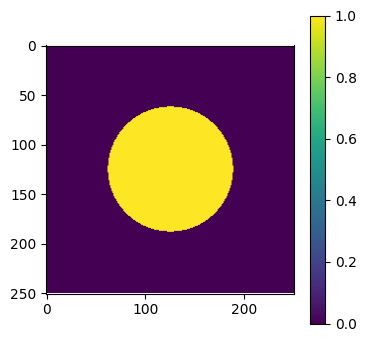

In [4]:
N = 251
ndim = 2
length = 1

# Create phase indicator (cylinder)
x = np.linspace(-0.5, 0.5, N)

if ndim == 3:
    Y, X, Z = np.meshgrid(x, x, x, indexing="ij")  # (N, N, N) grid
    phase = jnp.where(X**2 + Z**2 <= (0.2 / np.pi), 1.0, 0.0)  # 20% vol frac
else:
    X, Y = np.meshgrid(x, x, indexing="ij")  # (N, N) grid
    phase = jnp.where(X**2 + Y**2 <= (0.2 / np.pi), 1.0, 0.0)

plt.figure(figsize=(4, 4))
plt.imshow(phase)
plt.colorbar()
plt.show()


Similar to the examples for `Fourier-Galerkin` and `Moulinec-Suquet` tutorials, we define the `SpectralSpace` and `TensorOperator` objects.

In [5]:
tensor = TensorOperator(dim=ndim)
space = SpectralSpace(size=N, dim=ndim, length=length)


u_shape = make_field(dim=ndim, N=N, rank=1).shape
eps_shape = make_field(dim=ndim, N=N, rank=2).shape

Unlike `Fourier-Galerkin` and `Moulinec-Suquet` schemes, displacement-based FFT scheme doesnot require any projection operators. Since it solves the strong form of the problem, we need to define a symmetric gradient and divergence operators in Fourier space.


In [6]:
scheme = Fourier(space=space)

# nabla = scheme.gradient_operator
#nabla_sym = scheme.symmetric_gradient_operator
#div = scheme.divergence_operator

Defining the material parameters.

In [7]:
# Material parameters [grids of scalars, shape (N,N,N)]
lambda1, lambda2 = 10.0, 1000.0
mu1, mu2 = 0.25, 2.5
lambdas = lambda1 * (1.0 - phase) + lambda2 * phase
mu = mu1 * (1.0 - phase) + mu2 * phase

Now we can construct our preconditioner. We need to define a reference tensor $\mathbb{C}_0$ and pass it to the preconditioner. The reference tensor is defined as the average of the material parameters over the domain.

In [8]:
# --- Create a C0 reference tensor ---
lambda0 = jnp.mean(lambdas)
mu0 = jnp.mean(mu)
i = jnp.eye(ndim)
I4 = jnp.einsum("il,jk->ijkl", i, i)
I4rt = jnp.einsum("ik,jl->ijkl", i, i)
I4s = (I4 + I4rt) / 2.0
II = jnp.einsum("ij,kl->ijkl", i, i)
C0 = lambda0 * II + 2.0 * mu0 * I4s  # C0 is shape (d,d,d,d)

# --- Instantiate the Preconditioner ---
preconditioner_fn = HomogeneousPreconditioner(space=space, C0=C0, u_shape=u_shape)

krylov_solver_fn = eqx.Partial(
    preconditioned_conjugate_gradient, M_inv=preconditioner_fn
)


## Defining the strain and strain energy functions.

In [9]:
@eqx.filter_jit
def compute_strain(u: Array) -> Array:
    u = u.reshape(u_shape)
    u_hat = space.fft(u)
    return space.ifft(scheme.symm_grad(u_hat)).real


@eqx.filter_jit
def strain_energy(eps: Array) -> Array:
    eps = eps.reshape(eps_shape)
    eps_sym = 0.5 * (eps + tensor.trans(eps))
    energy = 0.5 * jnp.multiply(lambdas, tensor.trace(eps_sym) ** 2) + jnp.multiply(
        mu, tensor.trace(tensor.dot(eps_sym, eps_sym))
    )
    return energy.sum()


compute_stress = jax.jacrev(strain_energy)

In [12]:
class Residual(eqx.Module):
    """A callable module that computes the residual vector."""

    scheme: Fourier
    space: SpectralSpace = eqx.field(static=True)
    u_shape: tuple = eqx.field(static=True)

    # We can even pre-define the stress function if it's always the same
    # For this example, we'll keep your original `compute_stress` function
    # available in the global scope.

    @eqx.filter_jit
    def __call__(self, u_flat: Array, eps_macro: Array) -> Array:
        """
        This makes instances of this class behave like a function.
        It takes only the flattened vector of unknowns, as required by the solver.
        """
        u = u_flat.reshape(self.u_shape)
        eps = compute_strain(u)
        sigma = compute_stress(eps + eps_macro)
        sigma_hat = self.space.fft(sigma)
        residual_hat = self.scheme.div(sigma_hat)
        residual = self.space.ifft(residual_hat).real
        return residual.reshape(-1)


class Jacobian(eqx.Module):
    """A callable module that represents the Jacobian operator (tangent)."""

    scheme: Fourier
    space: SpectralSpace = eqx.field(static=True)
    u_shape: tuple = eqx.field(static=True)

    @eqx.filter_jit
    def __call__(self, du_flat: Array) -> Array:
        """
        The Jacobian is a linear operator, so its __call__ method
        represents the Jacobian-vector product.
        """
        du = du_flat.reshape(self.u_shape)
        deps = compute_strain(du)
        dsigma = compute_stress(deps)
        dsigma_hat = self.space.fft(dsigma)
        jvp_hat = self.scheme.div(dsigma_hat)
        jvp = self.space.ifft(jvp_hat).real
        return jvp.reshape(-1)



In [13]:
du = make_field(dim=2, N=N, rank=1)
u = make_field(dim=2, N=N, rank=1)

eps_macro = make_field(dim=2, N=N, rank=2)

residual_fn = Residual(scheme=scheme, space=space, u_shape=u_shape)
jacobian_fn = Jacobian(scheme=scheme, space=space, u_shape=u_shape)


applied_strains = jnp.linspace(0, 1e-2, num=5)

for inc, eps_avg in enumerate(applied_strains):
    # solving for elasticity
    eps_macro[:, :, 0, 0] = eps_avg
    eps_macro[:, :, 1, 1] = eps_avg

    residual_partial = eqx.Partial(residual_fn, eps_macro=eps_macro)

    b = -residual_partial(u)

    final_state = newton_krylov_solver(
        state=(du, b, u),
        gradient=residual_partial,
        jacobian=jacobian_fn,
        tol=1e-8,
        max_iter=10,
        krylov_solver=krylov_solver_fn,
        krylov_tol=1e-8,
        krylov_max_iter=20,
    )
    u = final_state[2]


eps = compute_strain(u) + eps_macro

sig = compute_stress(eps)


Converged, Residual value : 0.0
CG error = 0.00000000136012
CG error = 0.00000000000001
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
Didnot converge, Residual value : 3.594584393357459e-05
CG error = 0.00000000136012
CG error = 0.00000000000001
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
Didnot converge, Residual value : 3.594612400924596e-05
CG error = 0.00000000136012
CG error = 0.00000000000001
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
CG error = 0.00000000000000
Didnot converge,

Let us now plot the stresses and displacement fields

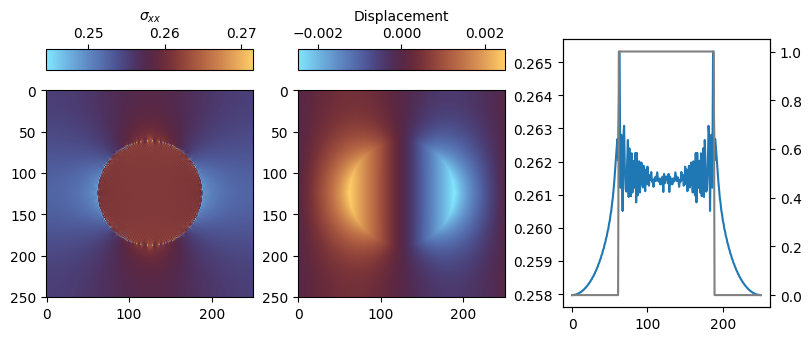

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3), layout="constrained")
cb1 = ax1.imshow(sig.at[:, :, 0, 0].get(), cmap="managua_r")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(cb1, cax=cax, label=r"$\sigma_{xx}$", orientation="horizontal", location="top")


cb2 = ax2.imshow(u.at[:, :, 1].get(), cmap="managua_r")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(cb2, cax=cax, label="Displacement", orientation="horizontal", location="top")

ax3.plot(sig.at[:, :, 0, 0].get()[:, int(N / 2)])
ax_twin = ax3.twinx()
ax_twin.plot(phase[int(N / 2), :], color="gray")
plt.show()
